# Liposome Analysis Tool

Welcome to the b.next nucleus v1.0.0-alpha1 Liposome Analysis Tool. This tool is one part of the **Containers** section of the b.next nucleus synthetic developer kit (SDK). For further information, look at the [Containers Documentation](https://b-next.notion.site/Nucleus-v1-alpha-Container-Documentation-7a69f1b2dc3a4dfeb680f58fdf1f2e79?pvs=4), or the [b.next nucleus release](https://www.notion.so/b-next/b-next-nucleus-0c2089e9bdae438d9ad63f90ac82c6b1). If you have any questions or comments, please reach out on the [nucleus mailing list](mailto:nucleus-discuss@bnext.bio).

# Getting started

## Setup and Installation

The analysis tool runs using python. It is assumed that you have a basic working knowledge of python and jupyter notebooks, and have a python environment installed on your computer. If you need to acquire these two requisite items, please check out the following resources: [Anaconda Python](https://docs.anaconda.com/free/anaconda/), [Jupyter Notebook Basics](https://learning.anaconda.cloud/jupyter-notebook-basics), [Start Programming with Jupyter Notebooks](https://builtin.com/data-science/anaconda-python). We strongly recommend using the Anaconda python distribution to more easily install working versions of the scientific and machine learning libraries required. 

You may install the prerequisites by following the instructions below, or by running the Installation cell directly below these instructions.

### 1. Prerequisites
In order to use this toolbox, you must have several python packages installed:
+ cellpose
+ pandas
+ seaborn
+ scikit-image
+ tifffile

Depending on the size of your data, you will also have a better time if you have a GPU and enough RAM to hold a number of images in memory simultaneously. We recommend:
+ A recent Nvidia GPU, at least a RTX 3060 or better.
+ 16GB of RAM

### A. Install automatically
We can try to automatically set up the environment.
1. Run the installation cell directly below these instructions by clicking on it and pressing the 'Run' button on the toolbar above.
2. Change to the new environment by opening `Kernel -> Change Kernel` on the menu bar and selecting the `Nucleus Liposome Analysis` kernel. 

### B. Install manually

#### 1. Setup a virtual environment
We recommend setting up a separate virtual environment in order to ensure the libraries do not conflict with others you may already have installed. You may do this by entering the toolbox directory and running:
```
conda create -n nucleus-liposome-analysis -f environment.yml
```
or creating it manually by running:
```
conda create -n nucleus-liposome-analysis pip ipykernel scipy scikit-image numpy matplotlib pandas seaborn
```

#### 2. Install CellPose
Next, enter the analysis environment and install cellpose and other required libraries by running:
```
pip install -r requirements.txt
```
or
```
pip install cellpose "cellpose[gui]" tifffile
```

#### 3. Register the ipython kernel
If you want to be able to access the liposome analysis environment directly from jupyterlab running in another environment, you may wish to install it as an ipykernel.

This step is optional; if you don't understand what's going on then don't worry about it.
```
python -m ipykernel install --user --name nucleus-liposome-analysis
```

In [ ]:
# Automatic Install
#
# Create a conda environment and install our required dependencies within it.
# Run this cell to create the environment by clicking 'Run' on the menu bar above.

!conda env create -f environment.yml
!conda run -n nucleus-liposome-analysis python -m ipykernel install --user --name nucleus-liposome-analysis

# Perform an Analysis

## Setup our notebook.
The following cells import the required libraries and functions required for our analysis.

In [1]:
# %matplotlib widget

import math
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage as ndi
import skimage as ski
import skimage.measure as measure
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
import pprint as pp
import glob
import os
import logging
import random
import datetime
from IPython import display
import ipywidgets as w
from ipywidgets import interact, interactive, fixed, interact_manual
from cellpose import models, plot, utils, transforms
from cellpose.io import imread

In [2]:
# Configuration constants
MAX_COL = 8

# Analysis functions
def show_outlines(img, mask):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    outX, outY = np.nonzero(utils.masks_to_outlines(mask))
    imgout = img.copy()
    imgout[outX, outY] = np.array([255,255,0])
    ax.imshow(imgout)

def get_particles(img, mask):
    particle_count = mask.max()
    
    particles = list()
    particle_masks = list()

    for i in range(0, particle_count):
        x, y = (mask==i+1).nonzero() # Masks are indexed from 1
        left, top = x.min(), y.min()
        right, bottom = x.max(), y.max()
        particle = img[left:right,top:bottom]
        particle_mask = mask[left:right,top:bottom]
        
        # print(i, left, right, top, bottom, particle.shape)
        particles.append(particle)
        particle_masks.append(particle_mask)
        
    return particles, particle_masks

def show_particles(particles, channels=[0,1,2], outlines=False, equalize=True):
    if type(channels) is not list:
        channels = [channels]
        
    particle_count = len(particles)

    cols = min(MAX_COL, particle_count)
    rows = math.ceil(particle_count / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12,12), sharex=True, sharey=True)

    max_width = max([ p.shape[0] for p in particles ])
    max_height = max([ p.shape[1] for p in particles ])   

    for ax in axes.flatten():
        ax.set_facecolor("black")
        ax.set_axis_off()
    
    for i, particle in enumerate(particles):
        width, height = particle.shape[:2]
        pad_x = (max_width - width) // 2
        pad_y = (max_height - height) // 2

        if equalize:
            p = ski.exposure.equalize_adapthist(particle)
        else:
            p = ski.util.img_as_float(particle.copy())

        if outlines:
            outX, outY = np.nonzero(utils.masks_to_outlines(outlines[i]))
            p[outX, outY] = np.array([1.0 * len(channels)])
            
        img = np.zeros((max_width, max_height, 3), dtype=p.dtype)
        img[pad_x:pad_x+width, pad_y:pad_y+height, :p.shape[2]] = p

        ax = axes.flatten()[i]
        
        for c in range(0, img.shape[2]):
            if c not in channels:
                img[:,:,c] = 0
        
        ax.imshow(img)
        
    return fig, axes
    
def find_particles(model, name, img, dia=80, channels=[0,0]):
    # plt.figure()
    # plt.imshow(img)
    # return [], []
    logger = logging.getLogger()
    logger.debug("Finding particles in {}".format(name))
    
    if len(img.shape) < 3:
        img = img[:, :, np.newaxis]
        
    mask, flows, styles, diams = model.eval(img, diameter=dia, channels=channels)
    
    logger.debug("Determining properties")
    props = pd.DataFrame(measure.regionprops_table(mask, img[:,:], properties=['label', 'area', 'feret_diameter_max', 'axis_major_length', 'axis_minor_length', 'perimeter', 'intensity_mean', 'image_intensity']))
    props['circularity'] = (4 * math.pi * props.area) / (props.perimeter ** 2)
    

        
    logging.debug(img.shape)
    
    for c in range(0, img.shape[2]):
        logging.debug("Calculating derived properties on channel {}".format(c))
        # props["intensity_mean_{:02d}".format(i)] = measure.regionprops(mask, img[:,:,i]).intensity_mean
        # print(measure.regionprops(mask)[i].slice)
        # props.loc[i, "intensity_norm_{:02d}".format(i)] = img[:,:,c][measure.regionprops(mask)[i].slice].sum() / props['area']
        
        props["intensity_norm_{:02d}".format(c)] = props['image_intensity'].apply(lambda x: x[:,:,c].sum()) / props['area']
        props['circularity'] = (4 * math.pi * props.area) / (props.perimeter ** 2)

    logger.debug("Extracting particles")
    particles, particle_masks = get_particles(img, mask)
    
    # data = list()
    # for i in range(0, len(particles)):
    #     point = dict()
    #     point['name'] = name
    #     point['particle'] = particles[i]
    #     point['particle_mask'] = particle_masks[i]
    #     point['dia'] = dia
    #     data.append(point)
        
    return particles, particle_masks, props

In [3]:
# Set up logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Set up model
model = models.Cellpose(gpu=True, model_type='cyto')

## Load our data

The analysis toolbox expects to analyze an image stored in the TIFF file format. Most (really, all) microscopes should be able to export images in this file format. See your user manual for further information.

Point the analysis tool at a directory containing the images you wish to analyze. You should make sure that the directory only contains images you want to analyze; too many images could take a long time to run and unexpected images may affect the results.

We prefer to create directories for each experiment, named for the day the experiment was started and with a description of what it is. For example: `20230925-pure-liposome-gfp`.

In [7]:
from ipyfilechooser import FileChooser
import time

experiment_directory = "./sample-data/"
experiment_files = []

output_files = w.Output()
@output_files.capture(clear_output=True)
def change_experiment_directory(fc):
    if not fc:
        return
    
    global experiment_directory
    global experiment_files
    
    experiment_directory = fc.selected_path
    experiment_files = glob.glob(experiment_directory + "/*.tif")

    # print("Directory:", experiment_directory)
    # print()
    print("Files:")
    for file in experiment_files:
        print(os.path.basename(file))

fc = FileChooser('.')
# fc.show_only_dirs = True
# fc.title = '<b>Select experimental directory</b>'
fc.register_callback(change_experiment_directory)
# display(fc)
# output_files = w.interactive_output(change_experiment_directory, {'directory': fc})

# fc.observe(change_experiment_directory, "on_filename_change")
w.HBox([fc, output_files])

In [73]:
logger.setLevel(logging.DEBUG)

## Find particles

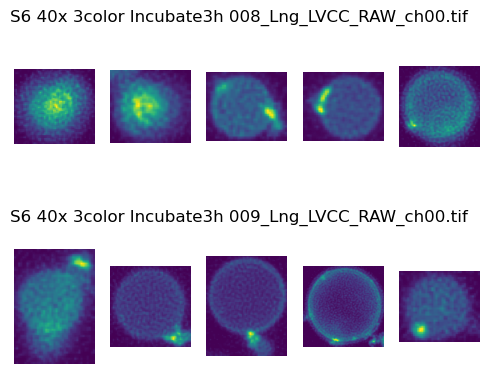

In [396]:
all_particles = list()
all_particle_masks = list()
all_props = list()

logger.info("Beginning analysis run on {} files in {}".format(len(experiment_files), experiment_directory))

EXAMPLE_PARTICLE_COUNT = 5

fig = plt.figure(figsize=(6,4));
subfigs = fig.subfigures(nrows=len(experiment_files))
    
for i, target in enumerate(experiment_files):
    name = os.path.basename(target)
    logger.info("Processing {}".format(name))

    image = imread(target)
    logger.info("Image is {} dimensions".format("x".join([str(x) for x in image.shape])))
    
    particles, particle_masks, props = find_particles(model, target, image)
    logger.info("{}: found {} particles".format(name, len(particles)))
    
    subfigs[i].suptitle(name)
    axes = subfigs[i].subplots(1, EXAMPLE_PARTICLE_COUNT)
    for j, particle in enumerate(random.choices(particles, k=EXAMPLE_PARTICLE_COUNT)):
        axes[j].set_axis_off()
        axes[j].imshow(particle);
        
    display.clear_output(wait=True)
    display.display(fig)
        
    all_particles.append(particles)
    all_particle_masks.append(particle_masks)
    
    props["name"] = name
    all_props.append(props)

plt.close()
all_props_df = pd.concat(all_props).reset_index(drop=True)

## Filter particles

Here we are going to set some basic boundaries on which liposomes we will use for further analysis. This helps clean up objects which look like liposomes, or which are liposomes but which we might want to remove. For example, we often see multilamellar liposomes which contain many smaller liposomes within them. These liposomes are very bright, throwing off any kind of intensity distribution we might wish to calculate. Likewise, some diffraction artifacts (lens flare) can look very similar to a liposome and accidentally get picked up; these artifacts tend to be dimmer than real liposomes.

There are two boundary parameters you can manipulate:
1. Normalized Intensity (`inorm`): This is a measure of the total intensity of the detected liposome, normalized by liposome size.
2. Circularity (`circ`): this is a measure of how circular the detected liposome is. You may or may not wish to include misshapen particles; this parameter can also be helpful to exclude other erroneously-chosen particles (for example, lipid aggregates).

The interface below will display a selection of 10 random particles from each image you analyzed. Set the upper and lower boundaries for each parameter by changing the `_upper` and `_lower` sliders for each parameter. Particles within the boundaries will be highlighted in green, while particles which fall outside one or both boundaries will be highlighted in red.

Once you are happy with the 'good' and 'bad' particles selected, continue to the next step.

In [406]:
EXAMPLE_PARTICLE_COUNT = 16

circularity_bounds = (props['circularity'].quantile(.1), 1) #props['circularity'].quantile(.9))
intensity_bounds = (props['intensity_norm_00'].quantile(.1), props['intensity_norm_00'].quantile(.9))

fig = plt.figure(figsize=(12,8));
subfigs = fig.subfigures(nrows=len(experiment_files));

all_example_particles = list()

for i, particles in enumerate(all_particles):
    subfigs[i].suptitle(name);
    
    rows = EXAMPLE_PARTICLE_COUNT // MAX_COL
    cols = MAX_COL
    axes = subfigs[i].subplots(rows, cols);
    
    example_particles = random.choices(range(0,len(particles)), k=EXAMPLE_PARTICLE_COUNT)
    max_width = max([ particles[p].shape[0] for p in example_particles ])
    max_height = max([ particles[p].shape[1] for p in example_particles ])   
    
    for j, p in enumerate(example_particles):
        axes.flatten()[j].set_axis_off();
        
        particle = particles[p]
        width, height = particle.shape[:2]
        pad_x = (max_width - width) // 2
        pad_y = (max_height - height) // 2

        img = np.zeros((max_width, max_height, 1), dtype=particle.dtype)
        img[pad_x:pad_x+width, pad_y:pad_y+height] = particle
        
        axes.flatten()[j].imshow(img);
    
    all_example_particles.append(example_particles)

plt.close()

inorm_min = all_props_df['intensity_norm_00'].min()
inorm_max = all_props_df['intensity_norm_00'].max()

@interact(inorm_lower=(inorm_min, inorm_max), inorm_upper=(inorm_min,inorm_max), circ_lower=(0.0,1.0,0.01), circ_upper=(0.0,1.0,0.01), continuous_update=False)
def update_bounds(inorm_lower=all_props_df['intensity_norm_00'].quantile(.1), inorm_upper=all_props_df['intensity_norm_00'].quantile(.9), circ_lower=0.7, circ_upper=1.0):
    global circularity_bounds
    global intensity_bounds
    
    circularity_bounds = (circ_lower, circ_upper)
    intensity_bounds = (inorm_lower, inorm_upper)
    
    display.clear_output(wait=True);

    for i, ps in enumerate(all_example_particles):
        for j, p in enumerate(ps):
            circ = all_props[i].loc[j, "circularity"]
            inorm = all_props[i].loc[j, "intensity_norm_00"]
            
            ax = subfigs[i].axes[j]
            ax.lines
            
            good = True
            if inorm_lower > inorm or inorm > inorm_upper:
                good = False
            if circ_lower > circ or circ > circ_upper:
                good = False
            
            color = "green" if good else "red"
            
            # ax.imshow(all_particles[i][p])
            for line in ax.get_lines():
                line.remove()
                
            ax.axvline(x=0, ymin=0, ymax=1, color=color, linewidth=8)
            ax.axvline(x=ax.get_xlim()[1], ymin=0, ymax=1, color=color, linewidth=8)
    
    display.display(fig);
    


interactive(children=(FloatSlider(value=176.22492488474504, description='inorm_lower', max=1309.1763265306122,…

## Analyse the particles

At this point, we're ready to go. You can run the analysis by running each Jupyter cell individually, or by clicking `Run -> Selected Cell and All Below` from here.

The plots generated will be saved in a directory under `./analysis/`, named for the date. If you re-run the cell below, a new directory will be generated for multiple runs on the same day.

In [398]:
all_props_df["good"] = all_props_df["intensity_norm_00"].between(*intensity_bounds) & all_props_df["circularity"].between(*circularity_bounds)

analysis_prefix = datetime.datetime.today().strftime('%Y%m%d') + "-"
analysis_dir = "./analysis/analysis-" + analysis_prefix

analyses = glob.glob(analysis_dir + "*")
if len(analyses) == 0:
    analysis_dir = analysis_dir + "0"
else:
    # We already have one, make a numbered one
    numbers = sorted([ int(os.path.basename(os.path.normpath(d)).split("-")[2]) for d in analyses ])
    next_num = numbers[-1] + 1
    analysis_dir = analysis_dir + "{}".format(next_num)
    
os.makedirs(analysis_dir)

### Summary


/opt/anaconda3/envs/liposome-analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


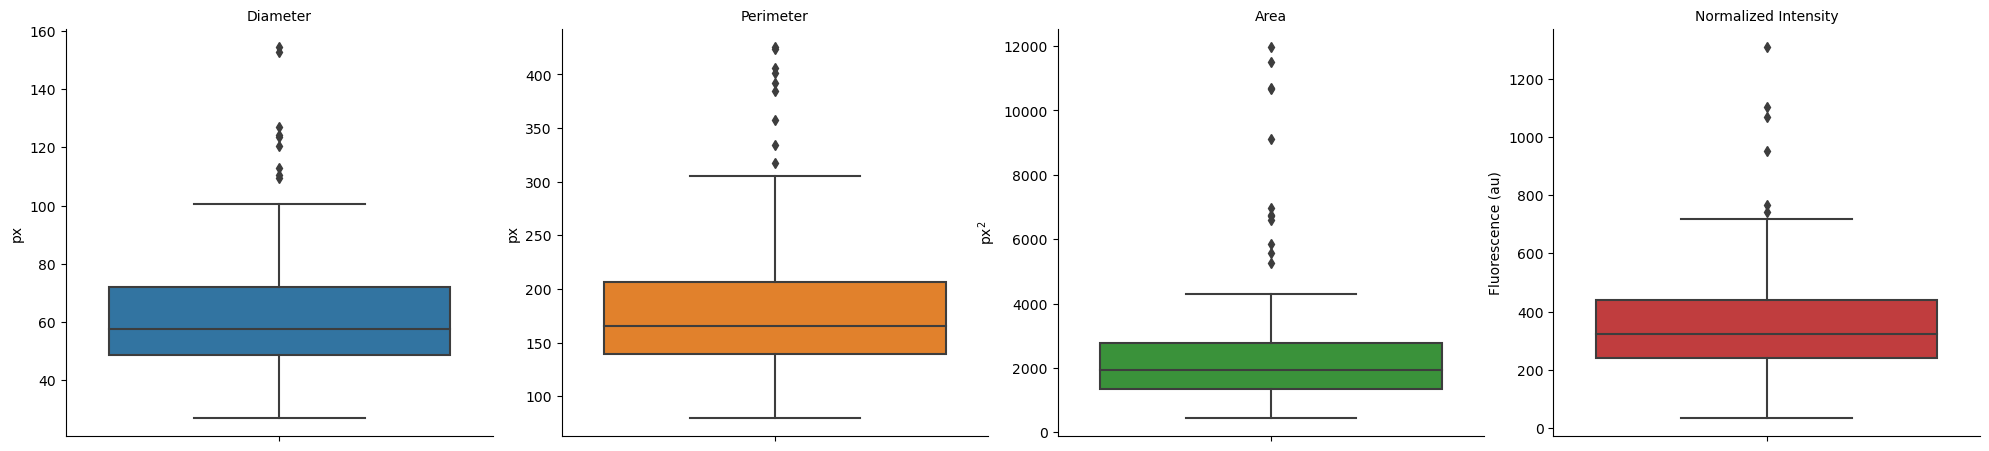

In [399]:
all_props_df["Diameter"] = all_props_df["feret_diameter_max"]
all_props_df["Perimeter"] = all_props_df["perimeter"]
all_props_df["Area"] = all_props_df["area"]
all_props_df["Normalized Intensity"] = all_props_df["intensity_norm_00"]

g = sns.catplot(data=all_props_df.melt(value_vars=["Diameter", "Perimeter", "Area", "Normalized Intensity"]), x="variable", y="value", dodge=False, kind="box", hue="variable", col="variable", sharex=False, sharey=False)
g.set_xlabels("")
g.set_ylabels("")
g.set_xticklabels([])
g.set_titles("{col_name}")

map(lambda i, x: x.set_ylabel([i]), enumerate(g.axes.flatten()))
for i, ax in enumerate(g.axes.flatten()):
    ax.set_ylabel(["px","px","px$^2$","Fluorescence (au)"][i])
    
plt.savefig(analysis_dir + "/" + analysis_prefix + "summary.png")

#### Statistics

In [423]:
apd = all_props_df[["Area","Diameter","Normalized Intensity"]].describe().transpose()[["mean","std","min","max"]]
apd = apd.rename(columns=str.capitalize)
apd.style.format(precision=2)

,Mean,Std,Min,Max
Area,2579.66,2156.55,455.00,11965.00
Diameter,62.75,23.51,27.20,154.35
Normalized Intensity,364.00,203.20,35.02,1309.18


### Diameter

In [400]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/opt/anaconda3/envs/liposome-analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


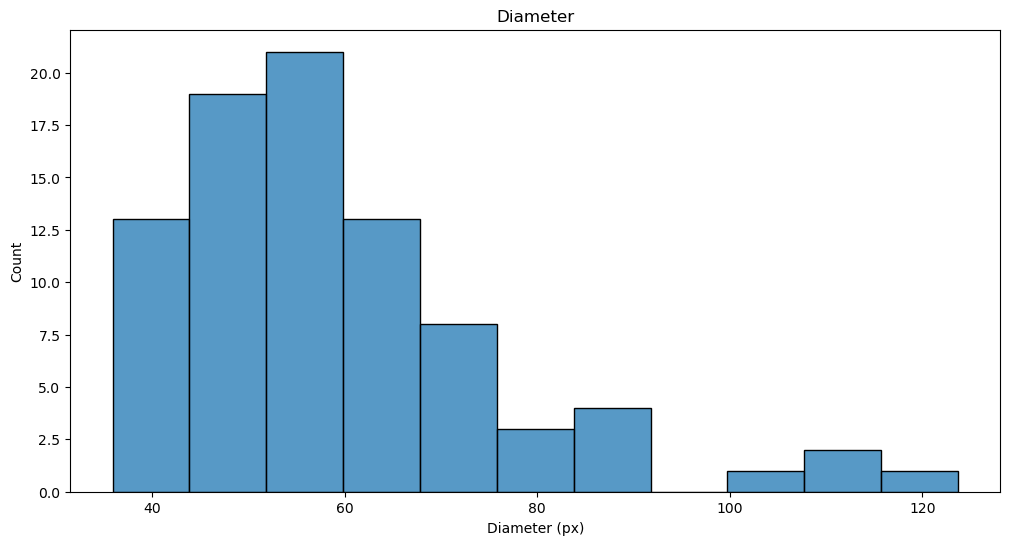

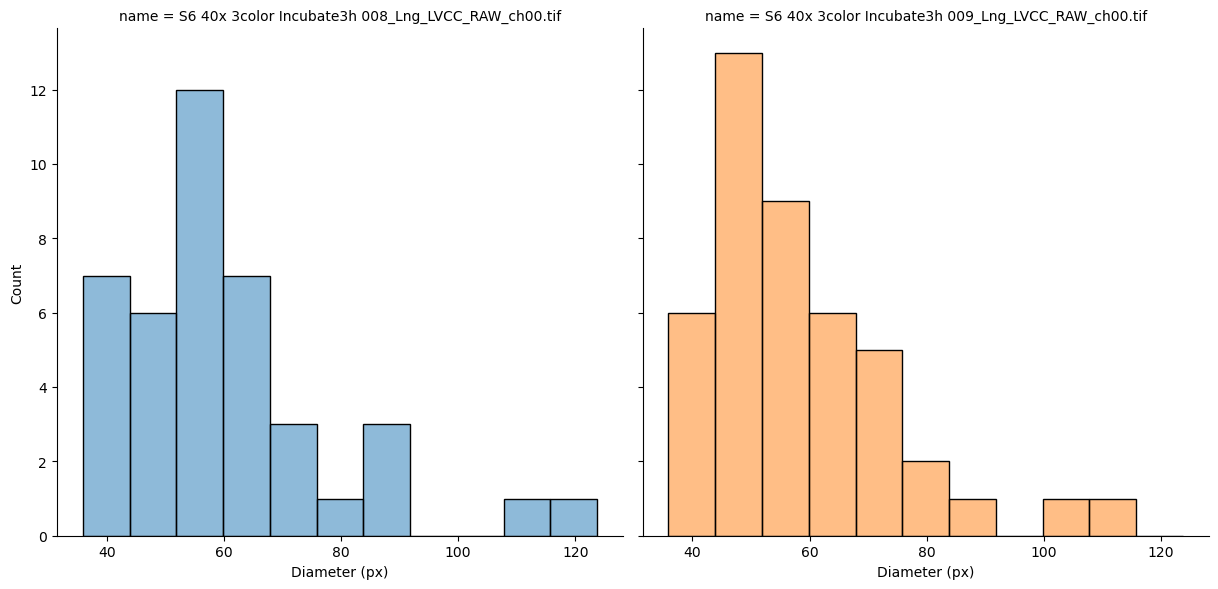

In [401]:
fig = plt.figure(figsize=(12,6))
ax = sns.histplot(data=all_props_df[all_props_df["good"]], x="feret_diameter_max", multiple="dodge")
ax.set_title("Diameter")
ax.set_xlabel("Diameter (px)");

plt.savefig(analysis_dir + "/" + analysis_prefix + "diameter-all.png")

ax = sns.displot(data=all_props_df[all_props_df["good"]], x="feret_diameter_max", hue="name", legend=False, col="name", col_wrap=4, height=6)
ax.set_xlabels("Diameter (px)")

plt.savefig(analysis_dir + "/" + analysis_prefix + "diameter-by-image.png")

### Perimeter

/opt/anaconda3/envs/liposome-analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


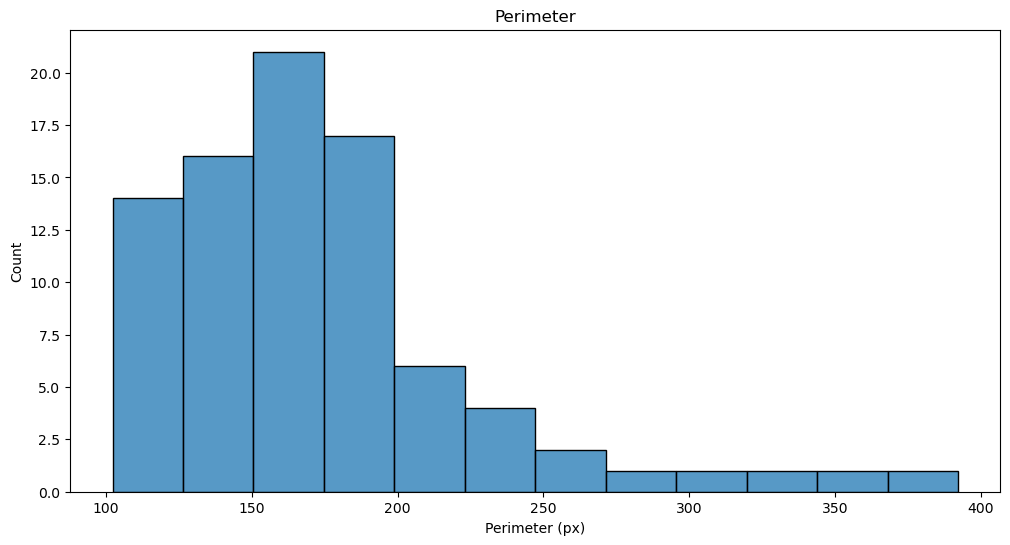

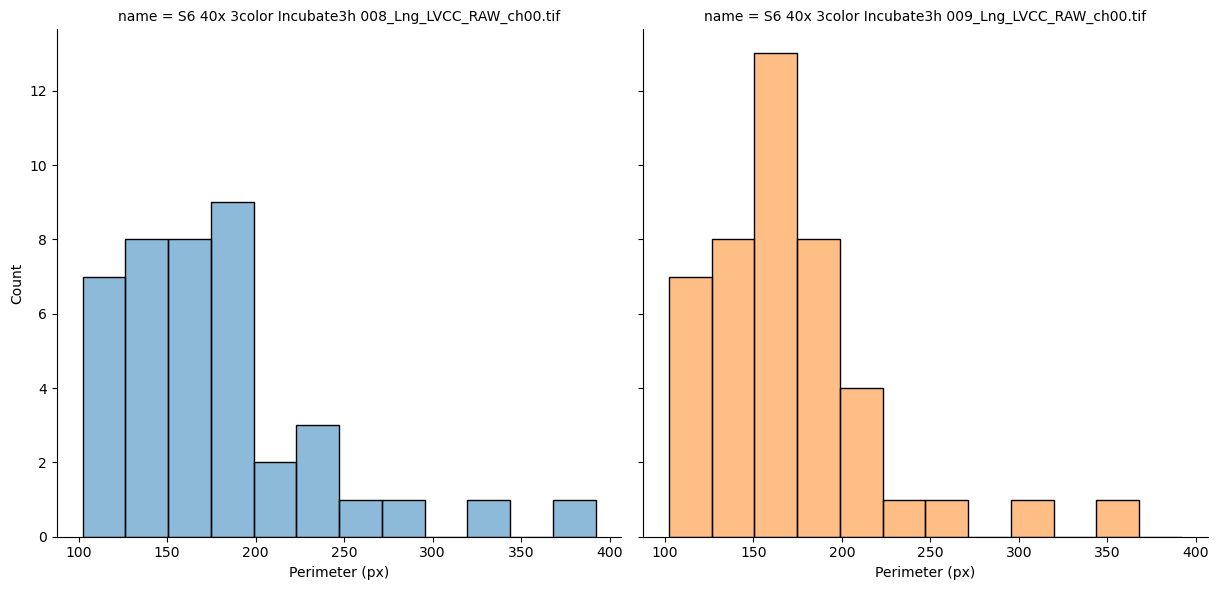

In [402]:
fig = plt.figure(figsize=(12,6))
ax = sns.histplot(data=all_props_df[all_props_df["good"]], x="perimeter")
ax.set_title("Perimeter")
ax.set_xlabel("Perimeter (px)");

plt.savefig(analysis_dir + "/" + analysis_prefix + "perimeter-all.png")

ax = sns.displot(data=all_props_df[all_props_df["good"]], x="perimeter", hue="name", legend=False, col="name", col_wrap=4, height=6)
ax.set_xlabels("Perimeter (px)");

plt.savefig(analysis_dir + "/" + analysis_prefix + "perimeter-by-image.png")

### Area

/opt/anaconda3/envs/liposome-analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


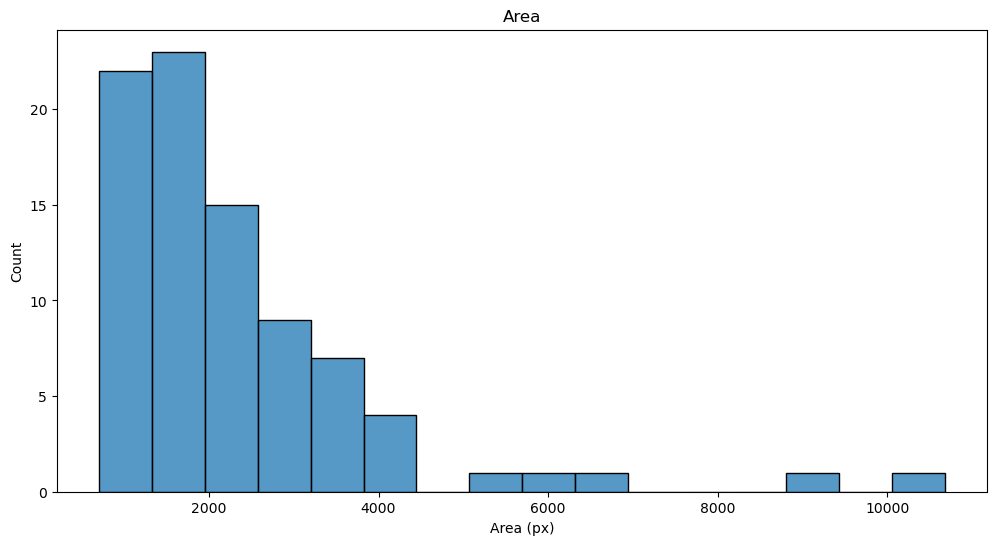

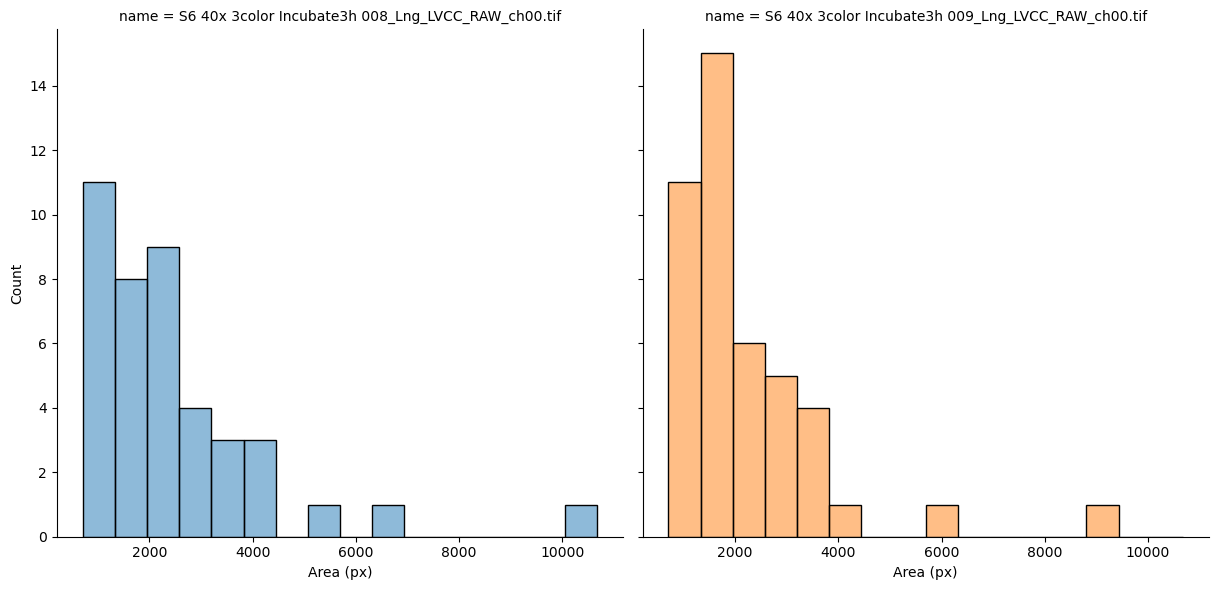

In [403]:
fig = plt.figure(figsize=(12,6))
ax = sns.histplot(data=all_props_df[all_props_df["good"]], x="area")
ax.set_title("Area")
ax.set_xlabel("Area (px)");

plt.savefig(analysis_dir + "/" + analysis_prefix + "area-all.png")

ax = sns.displot(data=all_props_df[all_props_df["good"]], x="area", hue="name", legend=False, col="name", col_wrap=4, height=6)
ax.set_xlabels("Area (px)");

plt.savefig(analysis_dir + "/" + analysis_prefix + "area-by-image.png")

### Normalized Intensity

/opt/anaconda3/envs/liposome-analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


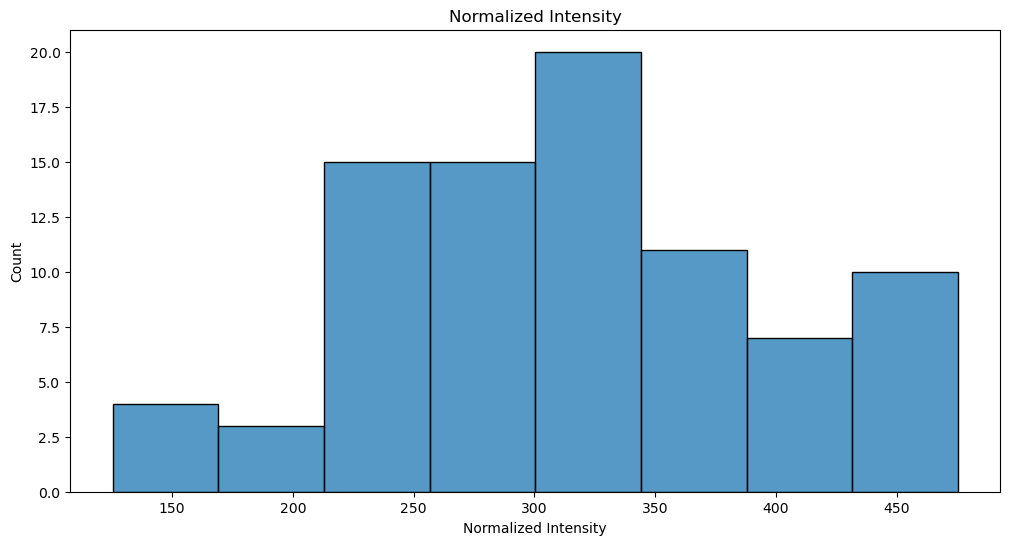

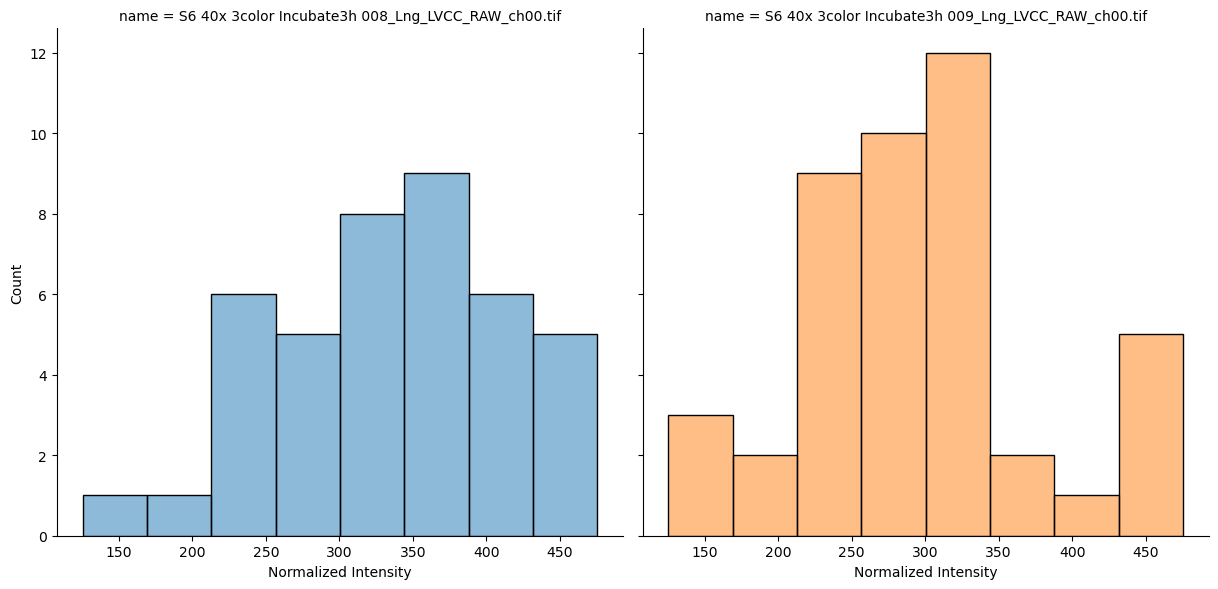

In [404]:
fig = plt.figure(figsize=(12,6))
ax = sns.histplot(data=all_props_df[all_props_df["good"]], x="intensity_norm_00")
ax.set_title("Normalized Intensity")
ax.set_xlabel("Normalized Intensity");

plt.savefig(analysis_dir + "/" + analysis_prefix + "intensity-all.png")

ax = sns.displot(data=all_props_df[all_props_df["good"]], x="intensity_norm_00", hue="name", legend=False, col="name", col_wrap=4, height=6)
ax.set_xlabels("Normalized Intensity");

plt.savefig(analysis_dir + "/" + analysis_prefix + "intensity-by-image.png")